[From《Dive into deep learning》](https://d2l.ai/chapter_recurrent-modern/gru.html)

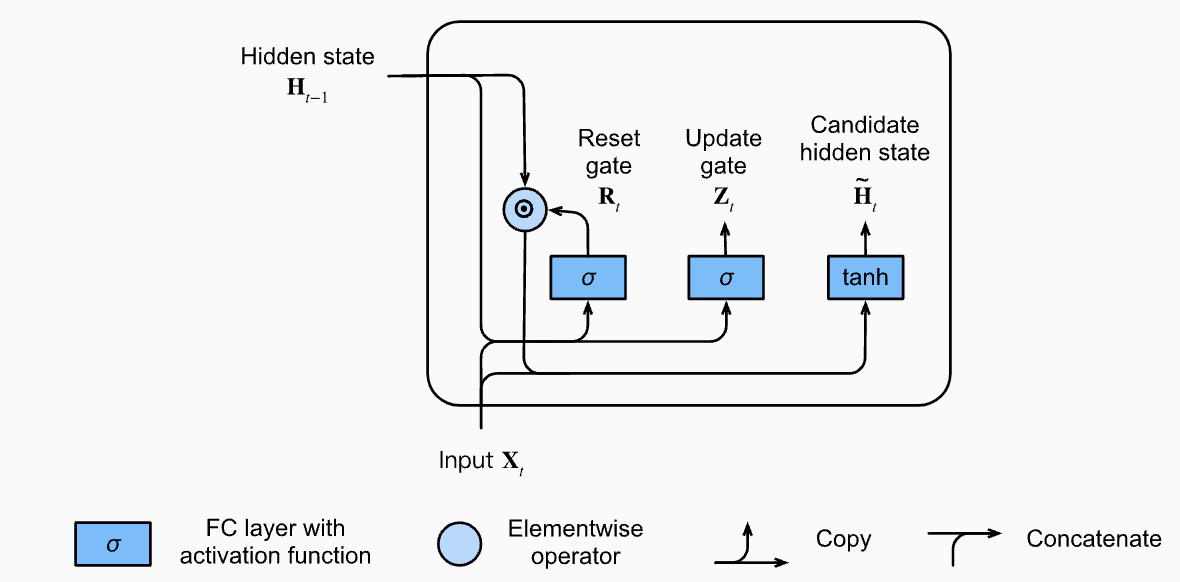

Mathematically, for a given time step $t$, suppose that the input is a minibatch $\mathbf{X}_t \in \mathbb{R}^{n \times d}$ (number of examples $=n$; number of inputs $=d$ ) and the hidden state of the previous time step is $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$ (number of hidden units $=h$ ). Then the reset gate $\mathbf{R}_t \in \mathbb{R}^{n \times h}$ and update gate $\mathbf{Z}_t \in \mathbb{R}^{n \times h}$ are computed as follows:
$$
\begin{aligned}
& \mathbf{R}_t=\sigma\left(\mathbf{X}_t \mathbf{W}_{\mathrm{xr}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{hr}}+\mathbf{b}_{\mathrm{r}}\right), \\
& \mathbf{Z}_t=\sigma\left(\mathbf{X}_t \mathbf{W}_{\mathrm{xz}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{hz}}+\mathbf{b}_{\mathrm{z}}\right),
\end{aligned}
$$
where $\mathbf{W}_{\mathrm{xr}}, \mathbf{W}_{\mathrm{xz}} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{\mathrm{hr}}, \mathbf{W}_{\mathrm{hz}} \in \mathbb{R}^{h \times h}$ are weight parameters and $\mathbf{b}_{\mathrm{r}}, \mathbf{b}_{\mathrm{z}} \in \mathbb{R}^{1 \times h}$ are bias parameters.

$$
\tilde{\mathbf{H}}_t=\tanh \left(\mathbf{X}_t \mathbf{W}_{\mathrm{xh}}+\left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{\mathrm{hh}}+\mathbf{b}_{\mathrm{h}}\right),
$$
where $\mathbf{W}_{\mathrm{xh}} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{\mathrm{hh}} \in \mathbb{R}^{h \times h}$ are weight parameters, $\mathbf{b}_{\mathrm{h}} \in \mathbb{R}^{1 \times h}$ is the bias, and the symbol $\odot$ is the Hadamard (elementwise) product operator. Here we use a tanh activation function.$$
\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}
$$
$$
\mathbf{H}_t=\mathbf{Z}_t \odot \mathbf{H}_{t-1}+\left(1-\mathbf{Z}_t\right) \odot \tilde{\mathbf{H}}_t
$$


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
def try_gpu(i=0):
  if torch.cuda.device_count() >= i+1:
    return torch.device(f'cuda:{i}')
  return torch.device('cpu')

In [3]:
# Define the parameters required for GRU
def get_params(input, num_hiddens, output, device):
  # reset gate
  W_xr = torch.normal(0, 0.01, size=(input, num_hiddens), device=device)
  W_hr = torch.normal(0, 0.01, size=(num_hiddens, num_hiddens), device=device)
  b_r = torch.zeros((num_hiddens), device=device)
  # update gate
  W_xz = torch.normal(0, 0.01, size=(input, num_hiddens), device=device)
  W_hz = torch.normal(0, 0.01, size=(num_hiddens, num_hiddens), device=device)
  b_z = torch.zeros((num_hiddens), device=device)
  # remaining parameters
  W_xh = torch.normal(0, 0.01, size=(input, num_hiddens), device=device)
  W_hh = torch.normal(0, 0.01, size=(num_hiddens, num_hiddens), device=device)
  b_h = torch.zeros((num_hiddens), device=device)
  # output
  W_oh = torch.normal(0, 0.01, size=(num_hiddens, output), device=device)
  b_o = torch.zeros((output), device=device)
  params = [W_xr, W_hr, b_r, W_xz, W_hz, b_z, W_xh, W_hh, b_h, W_oh, b_o]
  for param in params:
    param.requires_grad_(True)
  return params


In [4]:
def init_state(batch, num_hiddens, device):
  return (torch.zeros((batch, num_hiddens), device=device), )

In [5]:
def gru(X, state, params):
  # The shape of X is (num_steps, batch_size, features)
  W_xr, W_hr, b_r, W_xz, W_hz, b_z, W_xh, W_hh, b_h, W_oh, b_o = params
  H, = state
  outputs = []
  for x in X:
    r_t = torch.sigmoid(x @ W_xr + H @ W_hr + b_r)
    z_t = torch.sigmoid(x @ W_xz + H @ W_hz + b_z)
    H_tital = torch.tanh(x @ W_xh + (r_t * H) @ W_hh + b_h)
    H = z_t * H + (1 - z_t) * H_tital
    output = H @ W_oh + b_o
    outputs.append(output)
  return outputs[-1], (H, )

In [6]:
class GRU(nn.Module):
  def __init__(self, input, num_hiddens, output, params, init, forward, device):
    super().__init__()
    self.num_hiddens = num_hiddens
    self.init = init
    self.params = params(input, num_hiddens, output, device)
    self.forward = forward

  def __call__(self, x, state):
    shape = x.shape
    x = x.reshape(shape[0], -1, shape[-1])
    x = x.permute(1, 0, 2)
    return self.forward(x, state, self.params)


  def init_state_(self, batch, device):
    return self.init(batch, self.num_hiddens, device)

In [7]:
train_data = torchvision.datasets.MNIST('./data', train=True, download=True,
                                        transform=transforms.ToTensor())
test_data = torchvision.datasets.MNIST('./data', train=False, download=True,
                                       transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 241183599.47it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 60750097.20it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 74781754.05it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21143761.12it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [15]:
# params
lr = 0.01
batch_size = 256
num_epochs = 10
net = GRU(28, 128, 10, get_params, init_state, gru, try_gpu())

In [16]:
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)

In [17]:
from Common import plot_loss_acc

In [18]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.params, lr=lr)

In [19]:
def validation_rnn(model, data_loader, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for imgs, label in data_loader:
          imgs = imgs.to(device=device)
          label = label.to(device=device)
          state= model.init_state_(imgs.shape[0], device)
          y, _ = model(imgs, state)
          _, predicted = torch.max(y, dim=1)
          correct += (predicted == label).sum()
          total += label.size(0)
    return correct / total

In [20]:
def train_and_test_rnn(num_epochs, model, loss_function, optim, valid, train, test, device, figsize):
  loss_value = []
  acc_value = []
  for epoch in range(num_epochs):
    batch_loss = []
    for i, (img, label) in enumerate(train):
      img = img.to(device=device)
      label = label.to(device=device)
      state = model.init_state_(img.shape[0], device)
      y_hat, _ = model(img, state)
      l = loss_function(y_hat, label)
      batch_loss.append(l.item())
      optim.zero_grad()
      l.backward()
      optim.step()
      batch_loss.append(l.item())
      if (i+1) % 100 == 0:
        print(f'Step:{i+1}/{len(train)}, Epoch:{epoch+1}/{num_epochs}, Loss:{l.item():.4f}')
    avg_loss = sum(batch_loss) / len(batch_loss)
    loss_value.append(avg_loss)
    accuracy = valid(model, test, device)
    # The data is stored on the GPU, first moved to the CPU, and then converted to Python scalars.
    acc_value.append(accuracy.item())

    print(f'Step:{i+1}/{len(train)}, Epoch:{epoch+1}/{num_epochs}, Accuracy:{accuracy:.2f}')
  plot_loss_acc(loss_value, acc_value, figsize, num_epochs)

Step:100/235, Epoch:1/10, Loss:0.3632
Step:200/235, Epoch:1/10, Loss:0.1285
Step:235/235, Epoch:1/10, Accuracy:0.97
Step:100/235, Epoch:2/10, Loss:0.1272
Step:200/235, Epoch:2/10, Loss:0.1150
Step:235/235, Epoch:2/10, Accuracy:0.97
Step:100/235, Epoch:3/10, Loss:0.1224
Step:200/235, Epoch:3/10, Loss:0.0296
Step:235/235, Epoch:3/10, Accuracy:0.98
Step:100/235, Epoch:4/10, Loss:0.0368
Step:200/235, Epoch:4/10, Loss:0.0444
Step:235/235, Epoch:4/10, Accuracy:0.99
Step:100/235, Epoch:5/10, Loss:0.0747
Step:200/235, Epoch:5/10, Loss:0.0964
Step:235/235, Epoch:5/10, Accuracy:0.98
Step:100/235, Epoch:6/10, Loss:0.0406
Step:200/235, Epoch:6/10, Loss:0.0298
Step:235/235, Epoch:6/10, Accuracy:0.99
Step:100/235, Epoch:7/10, Loss:0.0232
Step:200/235, Epoch:7/10, Loss:0.0336
Step:235/235, Epoch:7/10, Accuracy:0.99
Step:100/235, Epoch:8/10, Loss:0.0183
Step:200/235, Epoch:8/10, Loss:0.0824
Step:235/235, Epoch:8/10, Accuracy:0.99
Step:100/235, Epoch:9/10, Loss:0.0282
Step:200/235, Epoch:9/10, Loss:0.0

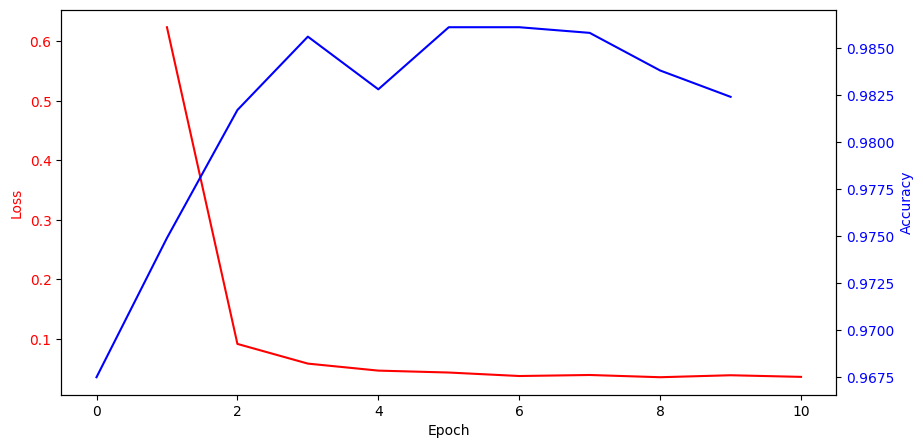

In [21]:
train_and_test_rnn(num_epochs, net, loss, optimizer, validation_rnn, train_loader,
                   test_loader, try_gpu(), figsize=(10, 5))